In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
import pathlib
if pathlib.Path().resolve().name == 'notebooks':
    %cd ..
%pwd

'c:\\Users\\Lenovo\\Desktop\\final_version\\NHL'

In [84]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
from src.data import NHLDataDownloader
from scipy import stats
from src.utils import normalize
import ipywidgets as widgets
from IPython.display import display
import pprint
from PIL import Image
import pickle


In [85]:

file_paths = ['0.14/df_2016_0.14.pkl', '0.14/df_2017_0.14.pkl', '0.14/df_2018_0.14.pkl', '0.14/df_2019_0.14.pkl']
# Create an empty list to hold DataFrames
dfs = []

# Load each pickle file into a DataFrame and add it to the list
for file_path in file_paths:
    with open(file_path, 'rb') as file:
        df = pickle.load(file)
        dfs.append(df)

# Concatenate the DataFrames
concatenated_df = pd.concat(dfs, ignore_index=True)

# Save the concatenated DataFrame to a new pickle file
with open('concatenated_data.pkl', 'wb') as file:
    pickle.dump(concatenated_df, file)

In [86]:
df = pd.read_pickle('concatenated_data.pkl')


In [87]:
df.columns

Index(['Game_id', 'Game_time', 'Period', 'Time', 'Team', 'OppTeam', 'Goal',
       'X', 'Y', 'Shooter', 'Goalie', 'Type', 'Empty_net', 'Strength', 'X_net',
       'Net_distance', 'Net_angle', 'Year'],
      dtype='object')

In [88]:
import pandas as pd
import numpy as np

# Charger votre DataFrame existant
# Assurez-vous que les noms de colonnes correspondent à ceux dans votre DataFrame

# Créer une nouvelle colonne "Distance du filet"
#df['Distance du filet'] = np.sqrt(df['X']**2 + df['Y']**2)
df['Distance_du_filet'] = df['Net_distance']

# Créer une nouvelle colonne "Angle relatif au filet"
df['Angle_relatif_au_filet'] = df['Net_angle']

# Créer une nouvelle colonne "est un but" (0 ou 1)
df['est_un_but'] = df['Goal'].astype(int)

# Remplacer les NaN dans la colonne "Empty_net" par 0
df['Empty_net'].fillna(0, inplace=True)
df['Empty_net'] = df['Empty_net'].astype(int)

# Créer une nouvelle colonne "Filet vide" (0 ou 1)
df['Filet_vide'] = df['Empty_net']

# Sélectionner uniquement les colonnes nécessaires
nouveau_df = df[['Distance_du_filet', 'Angle_relatif_au_filet', 'est_un_but', 'Filet_vide']]

# Afficher le nouveau DataFrame
print(nouveau_df)


        Distance_du_filet  Angle_relatif_au_filet  est_un_but  Filet_vide
0               13.000000              -22.619865           0           0
1               13.341664               77.005383           0           0
2               76.157731              -29.931512           0           0
3               57.974132              -14.995079           0           0
4               61.717096              -26.980231           0           0
...                   ...                     ...         ...         ...
305795          25.942244              -62.447188           0           0
305796          40.162171              -71.113913           0           0
305797          14.142136              -45.000000           0           0
305798          10.630146              -41.185925           0           0
305799          26.076810              -32.471192           0           0

[305800 rows x 4 columns]


In [89]:
import plotly.express as px

# Grouper par 'Distance du filet' et 'est_un_but' et compter le nombre d'occurrences
df_g = nouveau_df.groupby(['Distance_du_filet', 'est_un_but']).size().reset_index(name='Counts')

# Créer un histogramme
fig = px.histogram(df_g, 
                   x='Distance_du_filet', 
                   y='Counts',
                   color='est_un_but', 
                   labels={'est_un_but': 'Est un but'}, 
                   nbins=10,
                   title='Histogramme du nombre de tirs regroupés par distance')

# Ajouter un titre à l'axe x
fig.update_xaxes(title='Distance du filet')

# Ajouter un titre à l'axe y
fig.update_yaxes(title='Nombre de tirs')

# Afficher le graphique
fig.show()
fig.write_html("/Users/Lenovo/Desktop/article_blog/NHL-blog/hist1.html")


In [90]:
print(nouveau_df)

        Distance_du_filet  Angle_relatif_au_filet  est_un_but  Filet_vide
0               13.000000              -22.619865           0           0
1               13.341664               77.005383           0           0
2               76.157731              -29.931512           0           0
3               57.974132              -14.995079           0           0
4               61.717096              -26.980231           0           0
...                   ...                     ...         ...         ...
305795          25.942244              -62.447188           0           0
305796          40.162171              -71.113913           0           0
305797          14.142136              -45.000000           0           0
305798          10.630146              -41.185925           0           0
305799          26.076810              -32.471192           0           0

[305800 rows x 4 columns]


In [103]:
import pandas as pd
import plotly.express as px

# Suppose your DataFrame is called nouveau_df
bins_distance = pd.IntervalIndex.from_tuples([(i, i + 20) for i in range(0, 200, 20)])
bins_angle = pd.IntervalIndex.from_tuples([(i, i + 20) for i in range(-100, 120, 20)])

# Creating a copy of the DataFrame for distance
df_distance = nouveau_df.copy()
df_distance['Distance_Bins'] = pd.cut(df_distance['Distance_du_filet'], bins_distance)
df_distance['Distance_Bins'] = df_distance['Distance_Bins'].astype(str)  # Convert to string
df_distance_grouped = df_distance.groupby('Distance_Bins')['est_un_but'].mean().reset_index(name='Goal_Percentage')

# Creating a copy of the DataFrame for angle
df_angle = nouveau_df.copy()
df_angle['Angle_Bins'] = pd.cut(df_angle['Angle_relatif_au_filet'], bins_angle)
df_angle['Angle_Bins'] = df_angle['Angle_Bins'].astype(str)  # Convert to string
df_angle_grouped = df_angle.groupby('Angle_Bins')['est_un_but'].mean().reset_index(name='Goal_Percentage')

# Plotting for distance
fig_distance = px.bar(df_distance_grouped,
                      x='Distance_Bins',
                      y='Goal_Percentage',
                      title='Goal Percentage by Distance',
                      labels=dict(Distance_Bins='Distance (ft)', Goal_Percentage='Goal Percentage'))

# Plotting for angle
fig_angle = px.bar(df_angle_grouped,
                   x='Angle_Bins',
                   y='Goal_Percentage',
                   title='Goal Percentage by Angle',
                   labels=dict(Angle_Bins='Angle', Goal_Percentage='Goal Percentage'))

# Show the plots
fig_distance.show()
fig_angle.show()

fig_distance.write_html("/Users/Lenovo/Desktop/article_blog/NHL-blog/hist_distance.html")
fig_angle.write_html("/Users/Lenovo/Desktop/article_blog/NHL-blog/hist_angle.html")



Entre 0 et 50 unités de distance du filet, il y a une augmentation significative du nombre de tirs. Cela suggère que les joueurs ont tendance à prendre des tirs plus fréquemment lorsqu'ils sont très proche du filet.

Entre 50 et 200 unités de distance du filet, le nombre de tirs diminue considérablement. Cela peut indiquer que les joueurs sont moins enclins à tenter des tirs lorsqu'ils sont très éloignés du filet. 

La fréquence des buts est plus élevée entre 0 et 40 unités de distance du filet. Cela pourrait signifier que les tirs effectués à des distances proches du filet ont une plus grande probabilité de se transformer en buts.

In [53]:
import plotly.express as px
df_g = nouveau_df.groupby(['Angle_relatif_au_filet', 'est_un_but']).size().reset_index(name='Counts')

# Créer un histogramme
fig = px.histogram(df_g,
                   x='Angle_relatif_au_filet', 
                   y='Counts',
                   color='est_un_but',
                   labels={'est_un_but': 'Est un but'},
                   title='Histogramme du nombre de tirs regroupés par angle',
                   nbins=10)  # Augmenter le nombre de compartiments (bins) pour une meilleure répartition

# Ajouter un titre à l'axe x
fig.update_xaxes(title='Angle relatif au filet')

# Ajouter un titre à l'axe y
fig.update_yaxes(title='Nombre de tirs')

# Afficher le graphique
fig.show()
fig.write_html("/Users/Lenovo/Desktop/article_blog/NHL-blog/hist2.html")


Le nombre de tirs est très élevé lorsque l'angle est -40 et 40 atteignant jusqu'à 14000 tirs.  Ces angles correspondent probablement à des tirs plus directs vers le filet. Le nombre de trs pour des angles entre -100 et -50 et entre 50 et 100 semblent etre faible. Cela peut signifier que les joueurs évitent de tirer depuis des positions extrêmement latérales où il est plus difficile de viser avec précision et d'obtenir un bon angle d'attaque sur le filet.

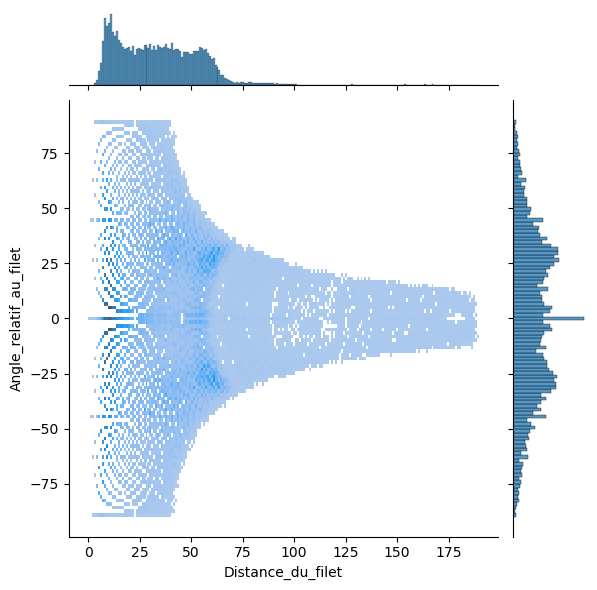

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Créer un jointplot
g = sns.jointplot(x='Distance_du_filet', y='Angle_relatif_au_filet', data=nouveau_df, kind='hist')

# Ajouter des titres
g.set_axis_labels('Distance_du_filet', 'Angle_relatif_au_filet')

# Afficher le graphique
plt.show()


Pour les distances proches (0-50) :

Il y a un grand nombre de tirs qui ont été effectués à des distances relativement proches du filet.
Ces tirs sont répartis sur toute la plage des angles possibles, ce qui suggère que les joueurs tirent de ces distances à partir de diverses directions.

Pour les distances plus éloignées (50-200) :

Le nombre de tirs diminue considérablement par rapport à ceux à courte distance.
Les tirs à ces distances semblent être plus concentrés autour de l'angle -25 à 25 degrés.
Ces observations peuvent indiquer des stratégies de jeu différentes en fonction de la distance au filet. Les tirs de près semblent être moins ciblés en termes d'angle, tandis que les tirs de loin semblent être plus concentrés vers le centre du filet. 

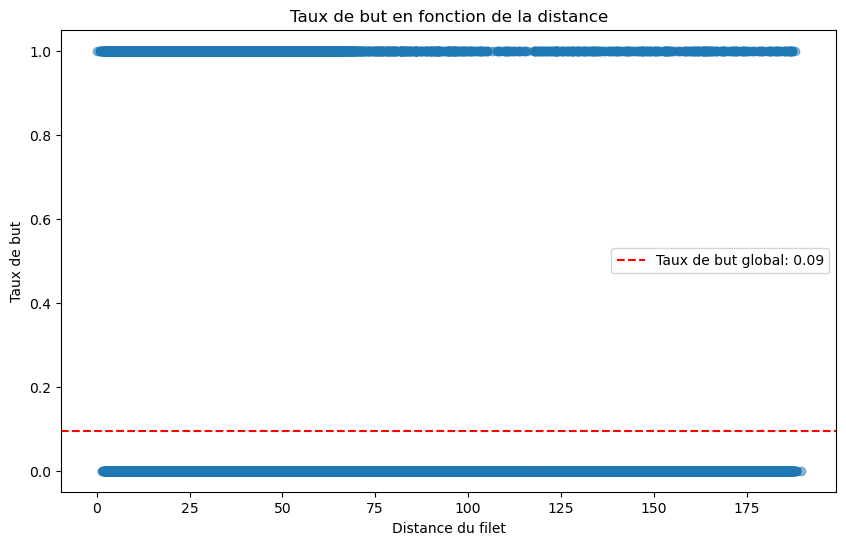

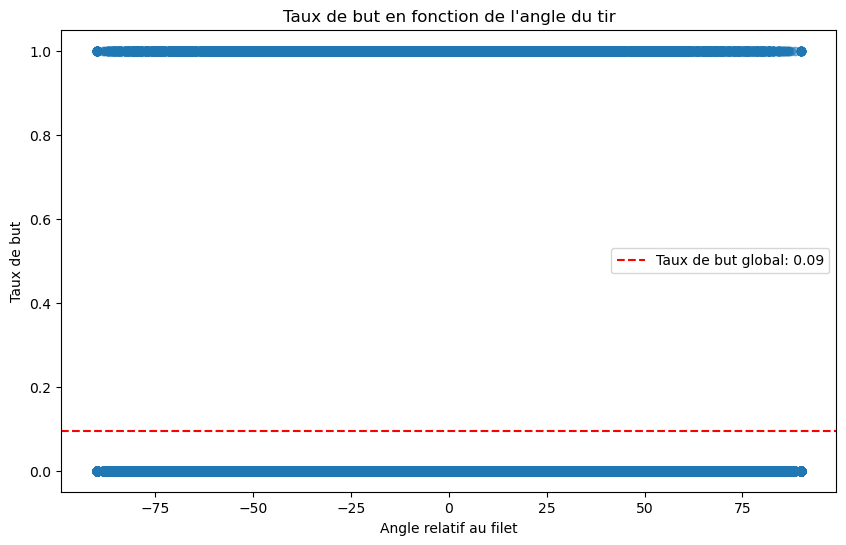

In [55]:
# Calculer le taux de buts
taux_buts = df['est_un_but'].sum() / (df['est_un_but'].sum() + (len(df) - df['est_un_but'].sum()))
#groupby(distance).goal.mean 
# Figure 1 : Taux de but en fonction de la distance
plt.figure(figsize=(10, 6))
plt.scatter(df['Distance_du_filet'], df['est_un_but'], alpha=0.5)
plt.xlabel('Distance du filet')
plt.ylabel('Taux de but')
plt.title('Taux de but en fonction de la distance')
plt.axhline(y=taux_buts, color='r', linestyle='--', label=f'Taux de but global: {taux_buts:.2f}')
plt.legend()
plt.show()

# Figure 2 : Taux de but en fonction de l'angle du tir
plt.figure(figsize=(10, 6))
plt.scatter(df['Angle_relatif_au_filet'], df['est_un_but'], alpha=0.5)
plt.xlabel('Angle relatif au filet')
plt.ylabel('Taux de but')
plt.title('Taux de but en fonction de l\'angle du tir')
plt.axhline(y=taux_buts, color='r', linestyle='--', label=f'Taux de but global: {taux_buts:.2f}')
plt.legend()
plt.show()



In [56]:
df_goals = nouveau_df[nouveau_df['est_un_but'] == 1]


df_goals['Counts'] = df_goals.groupby('Distance_du_filet')['Distance_du_filet'].transform('count')
# Créer un histogramme
fig = px.histogram(df_goals,
                   x='Distance_du_filet', 
                   y='Counts',
                   log_y=True,
                   color='Filet_vide',
                   labels={'Distance_du_filet': 'Distance du filet', 'Counts': 'Nombre de buts'},
                   title='Histogramme du nombre de tirs regroupés par angle',
                   nbins=10) 

fig.show()
fig.write_html("/Users/Lenovo/Desktop/article_blog/NHL-blog/hist4.html")


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11884\845712655.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



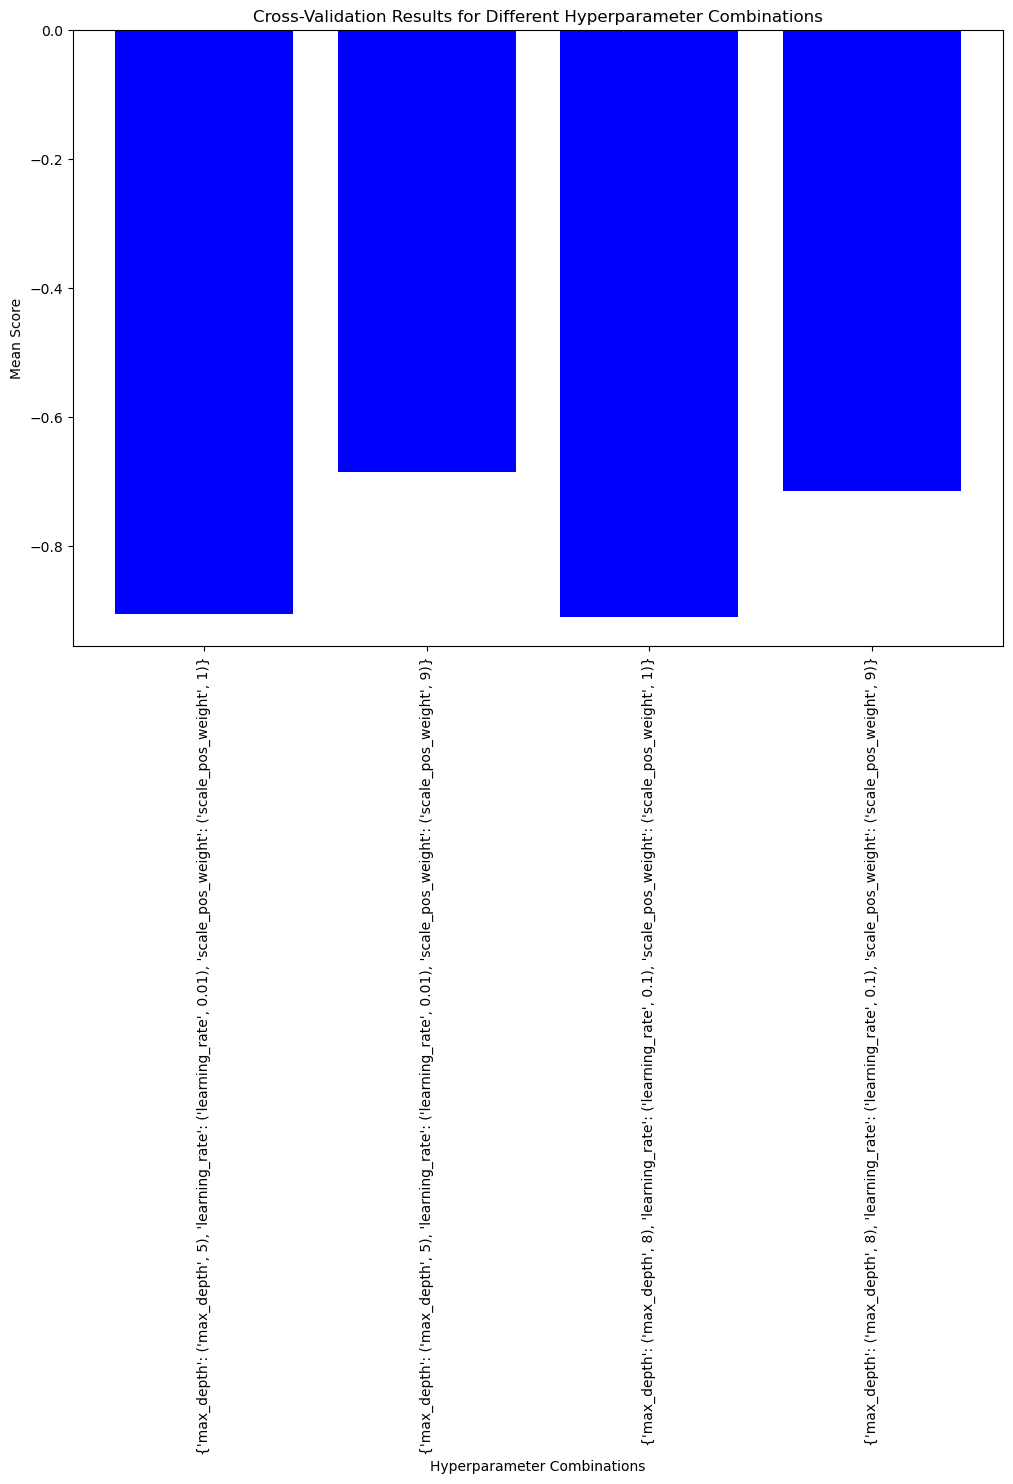

In [12]:
import seaborn as sns
import numpy as np
def plot_cv_results_bar(cv_results, param_names):
    param_combinations = [dict(zip(param_names, key)) for key in cv_results.keys()]
    scores = list(cv_results.values())

    # Take the mean of the scores for each combination
    mean_scores = [np.mean(score) for score in scores]

    # Create a bar plot
    plt.figure(figsize=(12, 8))
    plt.bar(range(len(param_combinations)), mean_scores, color='blue')
    
    # Set x-axis ticks and labels
    plt.xticks(range(len(param_combinations)), param_combinations, rotation='vertical')
    
    plt.title('Cross-Validation Results for Different Hyperparameter Combinations')
    plt.xlabel('Hyperparameter Combinations')
    plt.ylabel('Mean Score')
    plt.show()



# Call the function to plot the results as a bar plot
plot_cv_results_bar(cv_results, list(param_grid.keys()))

# Example usage
cv_results = {
    (('max_depth', 5), ('learning_rate', 0.01), ('scale_pos_weight', 1)): [-0.9054465257809665],
    (('max_depth', 5), ('learning_rate', 0.01), ('scale_pos_weight', 9)): [-0.6851707099187627],
     (('max_depth', 8), ('learning_rate', 0.1), ('scale_pos_weight', 1)): [-0.9098713045420285],
    (('max_depth', 8), ('learning_rate', 0.1), ('scale_pos_weight', 9)): [-0.7141341671086793],
    # Add more results here
}

param_grid = {
    'max_depth': [5, 8, 11],
    'learning_rate': [0.01, 0.05, 0.1],
    'scale_pos_weight': [1, 9],
}



